# Random search algorithm

In [1]:
import io
import os
import random
import torch
import json
import contextlib
from ultralytics import YOLO 
from mylib import simsettings
from mylib import myutils
from mylib import simtools
from mylib import yolo_patch_softmax as _
from constants import OBS_SCALE, CELL_SIDE, MAP_RESOLUTION, DISPLAY_STEP
from constants import AGENT_HEIGHT, AGENT_RADIUS 
from constants import MAX_ITER_COEF, CONFIDENCE_THRESHOLD, LOCATION_ERROR_THRESHOLD
from constants import ACTIONS   
from dotenv import load_dotenv
load_dotenv()

import habitat_sim
import habitat_sim.nav as nav
from habitat.utils.visualizations import maps
from habitat_sim.utils import common as utils

# Reload imported modules
%load_ext autoreload
%autoreload 2

# Load YOLO model
yolo_model = YOLO("yolo11x.pt")  

# Initialize cuda:0 device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
with contextlib.redirect_stdout(io.StringIO()):
    yolo_model = yolo_model.to(device)

WARNING ⚠️ user config directory '/root/.config/Ultralytics' is not writable, using '/tmp/Ultralytics'. Set YOLO_CONFIG_DIR to override.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


ModuleNotFoundError: No module named 'mylib'

In [2]:
# Load the JSON file for simulation
with open('simulation-data/simulations.json', 'r') as f:
    simulations = json.load(f)

# Select simulation 
simulation = simulations[53]

# Access its fields
SCENE = simulation["scene"]
TARGET_OBJECT = simulation["target_object"]
TARGET_OBJECT_ID = simulation["target_object_id"]
REAL_TARGET_LOCATION = simulation["target_object_location"]
INDEX = simulation["index"]

# Load the JSON file for RGB camera intrinsics
with open('simulation-data/camera-intrinsics.json', 'r') as f:
    intrinsics = json.load(f)

SCENE = "FloorPlan_Train3_1"
# Simulator configuration
dataset_config_file = os.path.join(os.getenv("AI2THOR_DATA"), "ai2thor-hab.scene_dataset_config.json")
sim_settings = {
    "seed": 1,
    "dataset": dataset_config_file,  # Scene dataset
    "scene": SCENE,  # Scene path
    "width": 1024,  # Spatial resolution of the observations
    "height": int(1024*OBS_SCALE),
    "default_agent": 0,
    "sensor_height": AGENT_HEIGHT,  # Height of sensors in meters
    "color_sensor": True,  # RGB sensor
    "depth_sensor": True,  # Depth sensor
    "enable_physics": False,  # kinematics only
}


# Initialize the simulator
cfg = simsettings.make_cfg(sim_settings)
sim = habitat_sim.Simulator(cfg)

Renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.230.02


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring


Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[11:40:06:885556]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'ai2thor-hab' : Lighting Layout Attributes '/home/joaocbranco/projects/habitat-meta/ai2thor-hab/ai2thor-hab/configs/scenes/RoboTHOR/FloorPlan_Train3_1.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
MeshTools::compile(): ignoring Trade::MeshAttribute::TextureCoordinates 1 as its binding slot is already occupied by Trade::MeshAttribute::TextureCoordinates 0
[11:40:07:116612]:[Warning]:[Sim] Simulator.cpp(595)::instanceStageForSceneAttributes : The active scene do

In [3]:
# Get the root node of the active scene graph
scene_root = sim.get_active_scene_graph().get_root_node()
scene_bb = scene_root.cumulative_bb
scene_dims = scene_bb.size()

# Define navmesh settings
navmesh_settings = simsettings.create_navmesh_settings(AGENT_HEIGHT, AGENT_RADIUS, max_climb=0.2, max_slope=45.0, include_static_objects=True)

# Recompute the navmesh for the current scene
sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

# Generate the top-down map --> 1 cm per pixel
topdown_map = maps.get_topdown_map(sim.pathfinder, height=0, meters_per_pixel=MAP_RESOLUTION, draw_border=True)
topdown_map, topdown_resolution = myutils.process_raw_topdown_map(topdown_map)

# Generate the coarse map --> 30 cm per pixel (robot has radius 15 cm)
grid_map = maps.get_topdown_map(sim.pathfinder, height=0, meters_per_pixel=CELL_SIDE, draw_border=False)
grid_map, grid_resolution = myutils.process_raw_grid_map(grid_map, sim.pathfinder)

# Find free cells in the grid map
grid_free_cells, map_free_cells, world_free_coords = myutils.find_free_cells(grid_map, grid_resolution, topdown_map, topdown_resolution, sim.pathfinder)
num_free_cells = len(grid_free_cells)

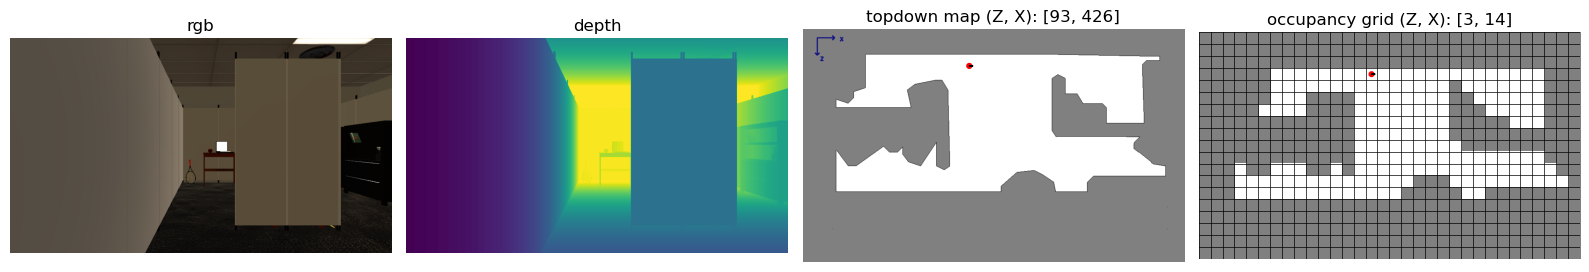

In [4]:
# Initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])

# Sample a random position (within the possible ones)
grid_position = random.choice(grid_free_cells)
idx = grid_free_cells.index(grid_position)
world_position = world_free_coords[idx]
map_position = map_free_cells[idx]

# Sample a random yaw rotation
agent_yaw = random.choice([0, 90, 180, 270])
agent_quart = myutils.yaw_to_quaternion(agent_yaw)

# Set agent state
agent_state = habitat_sim.AgentState()
agent_state.position = world_position
agent_state.rotation = agent_quart
agent.set_state(agent_state)

# Compute agent radius in both maps
min_bounds, max_bounds = sim.pathfinder.get_bounds()
x_dim = max_bounds[0] - min_bounds[0]
topdown_radius = (AGENT_RADIUS / x_dim * topdown_resolution[0])
grid_radius = (AGENT_RADIUS / x_dim * grid_resolution[0])

# Get initial agent position tuple and radius tuple
agent_radius = (topdown_radius, grid_radius)
agent_positions = (map_position, grid_position)

# Get initial observations and maps
observations = sim.get_sensor_observations(0)
rgb, depth = observations["color_sensor"], observations["depth_sensor"]

# Display the initial simulation state (maps + observations)
simtools.display_sim_state(rgb, depth, topdown_map, grid_map, agent_positions, agent_radius, agent_yaw)

In [5]:
# Metrics initialization
target_found = False
num_actions = 0
travelled_distance = 0.0
location_error = float("inf")

# Simulation parameters
MAX_ITER = int(num_free_cells * MAX_ITER_COEF)  # Maximum number of actions to perform
DISPLAY_STEP = MAX_ITER // 10 

# Main simulation loop
while (num_actions < MAX_ITER) and (not target_found):

    # Select an action randomly
    action = random.choice(list(ACTIONS))
    num_actions += 1

    # Check if the action is valid
    if not simtools.is_action_valid(action, grid_position, agent_yaw, grid_free_cells):
        continue 
    
    # Perform the action and update agent state
    grid_position, agent_yaw = simtools.perform_action(action, grid_position, agent_yaw)
    
    # Update the agent position and orientation
    idx = grid_free_cells.index(grid_position)
    map_position, world_position = map_free_cells[idx], world_free_coords[idx]
    agent_quart = myutils.yaw_to_quaternion(agent_yaw)
    agent_positions = (map_position, grid_position)

    # Compute travelled distance
    travelled_distance += simtools.compute_travelled_distance(agent_state.position, world_position)

    # Set agent state
    agent_state.position = world_position
    agent_state.rotation = agent_quart
    agent.set_state(agent_state)

    # Get observations
    obs = sim.get_sensor_observations(0)
    rgb, depth = obs["color_sensor"], obs["depth_sensor"]

    # YOLO Prediction
    results = yolo_model.predict(source=rgb[:,:,:3], device='cuda:0', conf=0.30, iou=0.40, verbose=False, max_det=10)
    detections = simtools.parse_yolo_detections(results)
    simtools.merge_rgb_yolo_outputs(rgb, detections)
    target_found, target_bbox = simtools.was_target_found(TARGET_OBJECT_ID, detections, CONFIDENCE_THRESHOLD)

    # Display the current simulation state (maps + observations)
    if not num_actions % DISPLAY_STEP:
        print("Iter:", num_actions, "\tAction:", action)
        simtools.display_sim_observations(rgb, depth)
        simtools.display_topdown_maps(topdown_map, grid_map, agent_positions, agent_radius, agent_yaw)

In [6]:
# Compute the target location if it was found
if target_found:
    # Real world position
    center_x, center_y = simtools.get_box_center(target_bbox)
    depth_value = depth[center_y, center_x]
    target_location = simtools.compute_real_world_position_from_pixel(agent_state.position, agent_state.rotation, depth_value, center_x, center_y, intrinsics)


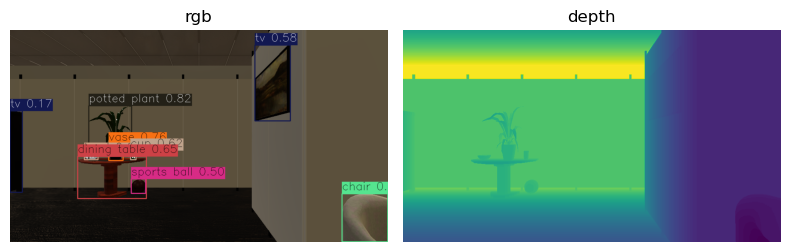

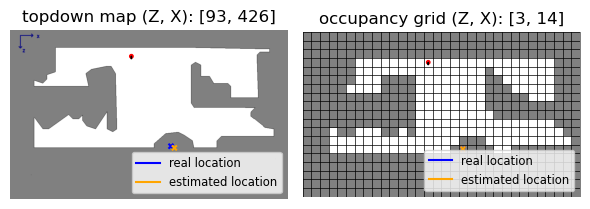


Target object <potted plant> found after 1 actions!
Found location: [    -4.6625   -0.043984     -1.1952]
Ground-truth location: [-4.789992809295654, 0.5929855108261108, -1.260035514831543]
Number of actions: 1
Travelled distance: 0.00 m
Computed location error: 0.143 m


In [7]:
# Evaluating correctness of the target detection
if target_found:
    # Location error
    location_error = simtools.compute_location_error(target_location, REAL_TARGET_LOCATION)

    # Compare with threshold
    if location_error > LOCATION_ERROR_THRESHOLD:
        print(f"\nLocation error {location_error:.3f} m exceeds threshold {LOCATION_ERROR_THRESHOLD} m. FAILURE!")
        target_found = False

    # Plot maps with target
    target_positions = simtools.get_2d_coords(target_location, topdown_resolution, grid_resolution, sim.pathfinder)
    real_target_positions = simtools.get_2d_coords(REAL_TARGET_LOCATION, topdown_resolution, grid_resolution, sim.pathfinder)
    simtools.display_sim_observations(rgb, depth)
    simtools.display_topdown_maps_with_target(topdown_map, grid_map, agent_positions, agent_radius, agent_yaw, target_positions, real_target_positions)

# Display simulation result and metrics
if target_found:
    print(f"\nTarget object <{TARGET_OBJECT}> found after {num_actions} actions!")
    print(f"Found location: {target_location}")
else:
    print(f"\nTarget object <{TARGET_OBJECT}> not found after {num_actions} actions!")

print(f"Ground-truth location: {REAL_TARGET_LOCATION}")
print(f"Number of actions: {num_actions}")
print(f"Travelled distance: {travelled_distance:.2f} m")
print(f"Computed location error: {location_error:.3f} m")

In [8]:
sim.close()